# cluster the cryo healthy scans (32,42,43) and the room temp healthy scans (50,51)
March 30, 2022
Needs to redo

In [1]:
import beamtime_config_2022
from beamtime_config_2022 import *

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from matplotlib import rc
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path
import seaborn as sns

import xrf_roif_2022

from xrf_roif_2022 import *

import xrfm_batches
from xrfm_batches import *

import fuzzy_kmeans_engine
from fuzzy_kmeans_engine import _format_soft_km_axes, soft_clustering_weights


%matplotlib inline

# define parameters

In [4]:
BASE_PATCH_WIDTH=32
selected_elm_maps=['Cu','Zn','Ca', 'K', 'P', 'S','Fe','Ni','Total_Fluorescence_Yield']
noise_type='none'
base_file_path = '/data02/AZC/March_2022_XRF_Data/'


# coarse_scan_names = ['bnp_fly0032.mda.h5']


coarse_scan_names = ['bnp_fly0032.mda.h5', 
                    'bnp_fly0042.mda.h5',
                    'bnp_fly0043.mda.h5',
                    'bnp_fly0050.mda.h5',
                    'bnp_fly0051.mda.h5']

# 'bnp_fly0050.mda.h5',
#                     'bnp_fly0051.mda.h5']



hdf5_string_list=['MAPS','MAPS','MAPS','MAPS','MAPS']
norm_ch_list=['US_IC','US_IC','US_IC','US_IC','US_IC']
selected_elm_maps_list=[selected_elm_maps,selected_elm_maps,selected_elm_maps,selected_elm_maps,selected_elm_maps]
noise_type_list = [noise_type,noise_type,noise_type,noise_type,noise_type]
bin_conv_elm_list=['P', 'P', 'P', 'P', 'Zn']
apply_gausssian_list=[False, False, False, False,False]
value_offset_list = [1e-12,1e-12,1e-12,1e-12,1e-12]


# assemble coarse scans

In [5]:
coarse_scans = XRFM_batch(base_file_path,
                  coarse_scan_names,
                 hdf5_string_list,
                 norm_ch_list,
                 selected_elm_maps_list,
                 noise_type_list,
                 bin_conv_elm_list,
                 value_offset_list,
                apply_gausssian_list,
                 BASE_PATCH_WIDTH,
                 print_pv=False,  
                 verbosity=False)

print('Bounding box width and height (pixels):' , BASE_PATCH_WIDTH)
print('Total extracted cells, features:', coarse_scans.X.shape)
print('Total extracted cell, cell size:', coarse_scans.X_bin.shape)


XRF /data02/AZC/March_2022_XRF_Data/bnp_fly0032.mda.h5
['Cu', 'Zn', 'Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'Total_Fluorescence_Yield']
(36, 14)
XRF /data02/AZC/March_2022_XRF_Data/bnp_fly0042.mda.h5
['Cu', 'Zn', 'Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'Total_Fluorescence_Yield']
(65, 14)
XRF /data02/AZC/March_2022_XRF_Data/bnp_fly0043.mda.h5
['Cu', 'Zn', 'Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'Total_Fluorescence_Yield']
(32, 14)
XRF /data02/AZC/March_2022_XRF_Data/bnp_fly0050.mda.h5
['Cu', 'Zn', 'Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'Total_Fluorescence_Yield']
(7, 14)
XRF /data02/AZC/March_2022_XRF_Data/bnp_fly0051.mda.h5
['Cu', 'Zn', 'Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'Total_Fluorescence_Yield']
(5, 14)
Bounding box width and height (pixels): 32
Total extracted cells, features: (145, 14)
Total extracted cell, cell size: (145, 32, 32)


(321, 321)
(321, 321)
(149, 321)
(321, 321)
(245, 321)


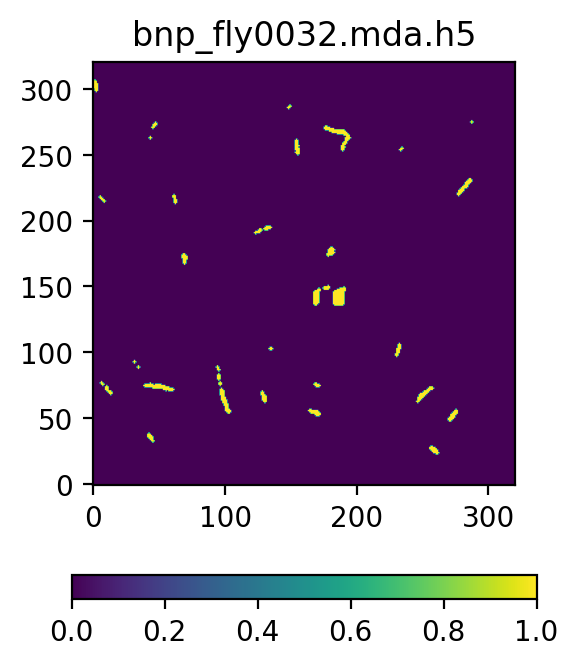

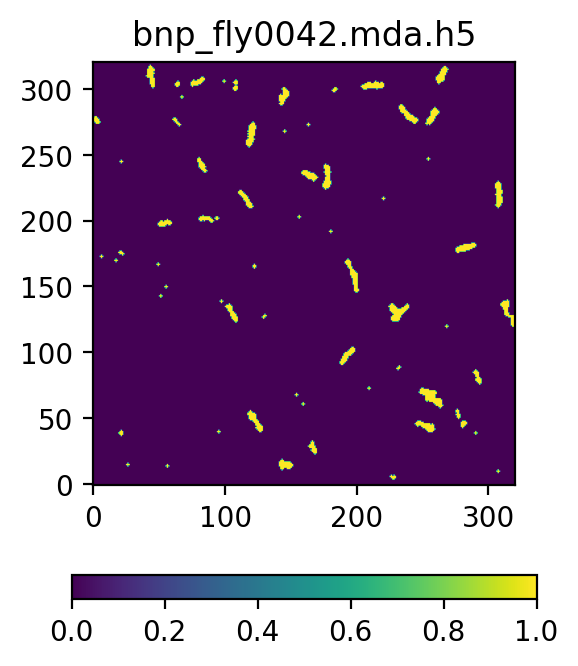

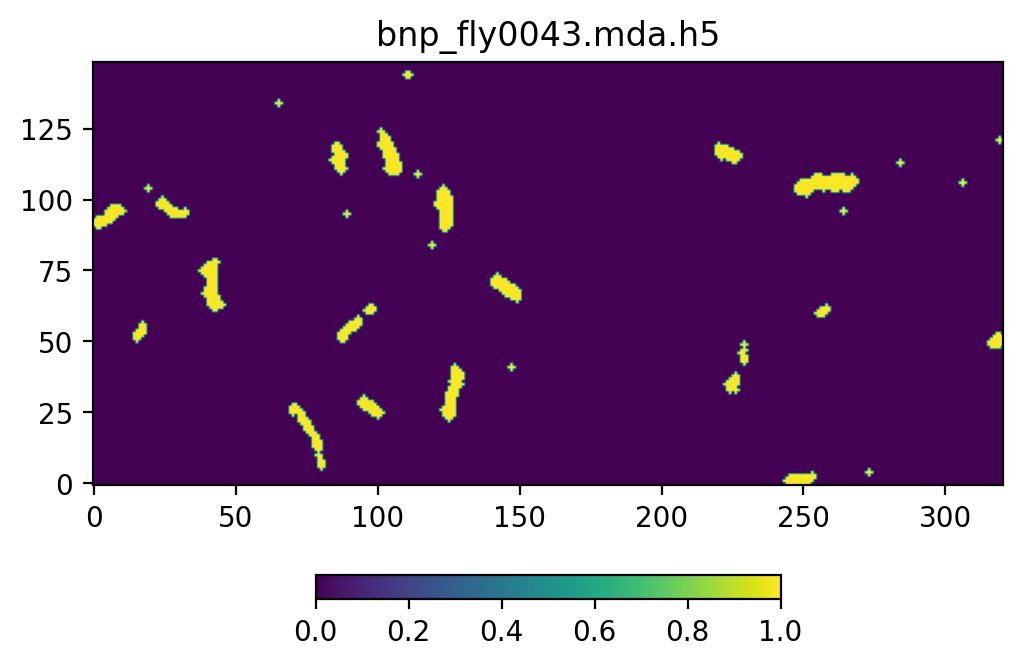

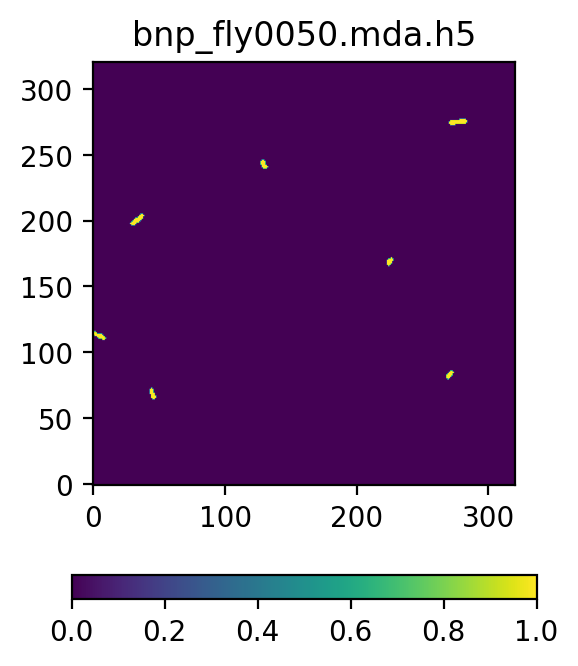

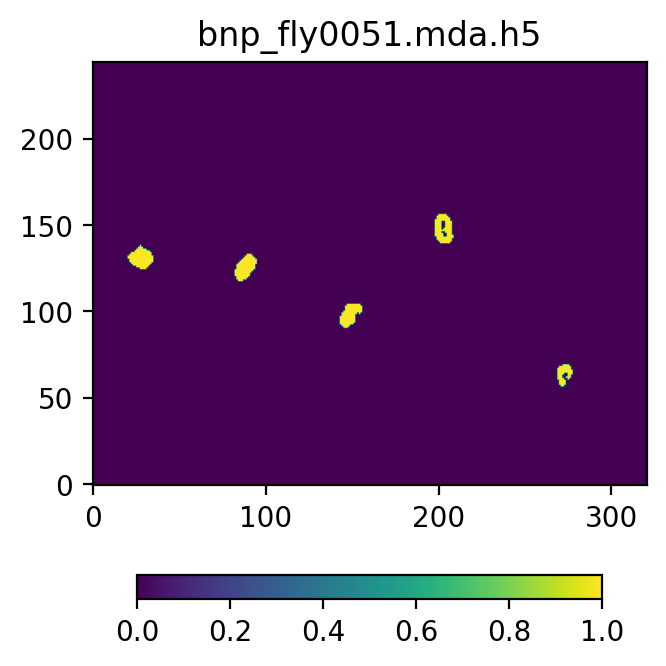

In [8]:
coarse_scans.plot_coarse_binary_images()

# construct dataframe with all the extracted information from defined features
inside the beamtime_XRF_image_extract_cell_method

In [5]:
principalDf = pd.DataFrame(
             columns = ['Pixel_count', 'area'])


principalDf['area'] = coarse_scans.X[:,0]
principalDf['eccentricity'] = coarse_scans.X[:,1]
principalDf['equivalent_diameter'] = coarse_scans.X[:,2]
principalDf['major_axis_length'] = coarse_scans.X[:,3]
principalDf['minor_axis_length'] = coarse_scans.X[:,4]
principalDf['perimeter'] = coarse_scans.X[:,5]
principalDf['K'] = coarse_scans.X[:,6]
principalDf['P'] = coarse_scans.X[:,7]
principalDf['Ca'] = coarse_scans.X[:,8]
principalDf['Zn'] = coarse_scans.X[:,9]
principalDf['Fe'] = coarse_scans.X[:,10]
principalDf['Cu'] = coarse_scans.X[:,11]
principalDf['BFY'] = coarse_scans.X[:,12]
principalDf['Pixel_count'] = coarse_scans.X[:,13].astype(int)   #Pixel_count column must exist

#add res and origins to dataframe here
#convert from list
principalDf['x_res'] = coarse_scans.X_x_res
principalDf['y_res'] = coarse_scans.X_y_res
principalDf['avg_res'] = coarse_scans.X_avg_res
principalDf['x_origin'] = coarse_scans.X_x_origin
principalDf['y_origin'] = coarse_scans.X_y_origin
principalDf['x_motor'] = coarse_scans.X_x_motor
principalDf['y_motor'] = coarse_scans.X_y_motor
principalDf['xrf_file']=coarse_scans.X_xrf_track_files




#assign scan names in dataframe
number_of_cells = principalDf['xrf_file'].to_numpy().shape[0]
coarse_scan_name=[]
for idx in range(number_of_cells):

    coarse_scan_name.append(os.path.split(principalDf['xrf_file'].to_numpy()[idx])[1])
principalDf['scan_name'] =  np.array(coarse_scan_name)  


display(principalDf)

,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ca,...,BFY,x_res,y_res,avg_res,x_origin,y_origin,x_motor,y_motor,xrf_file,scan_name
0,31,1.9375,0.883895,1.570637,2.291139,1.071534,5.035534,0.000042,0.000085,0.000074,...,0.007246,0.25,0.256287,0.253143,110.674377,-661.065186,175.174377,-654.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5
1,24,1.5000,0.905991,1.381977,2.133281,0.903012,4.181981,0.000069,0.000055,0.000065,...,0.007196,0.25,0.256287,0.253143,110.674377,-661.065186,121.424377,-652.315186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5
2,38,2.3750,0.937242,1.738949,2.952072,1.029325,6.096194,0.000054,0.000088,0.000078,...,0.007298,0.25,0.256287,0.253143,110.674377,-661.065186,178.674377,-648.065186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5
3,34,2.1250,0.919664,1.644881,2.676460,1.051060,5.681981,0.000044,0.000089,0.000127,...,0.007237,0.25,0.256287,0.253143,110.674377,-661.065186,152.424377,-647.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5
4,73,4.5625,0.981766,2.410219,5.681771,1.080060,11.303301,0.000055,0.000079,0.000064,...,0.007374,0.25,0.256287,0.253143,110.674377,-661.065186,135.424377,-645.315186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,74,4.6250,0.760358,2.426671,3.392264,2.203291,11.053301,0.000055,0.000127,0.000024,...,0.003534,0.25,0.255096,0.252548,-72.888748,-91.956627,-4.888748,-76.206627,/data02/AZC/March_2022_XRF_Data/bnp_fly0051.md...,bnp_fly0051.mda.h5
141,119,7.4375,0.833949,3.077291,4.255712,2.348479,10.949747,0.000040,0.000076,0.000016,...,0.003444,0.25,0.255096,0.252548,-72.888748,-91.956627,-35.888748,-67.456627,/data02/AZC/March_2022_XRF_Data/bnp_fly0051.md...,bnp_fly0051.mda.h5
142,133,8.3125,0.827593,3.253276,4.352950,2.443433,10.717514,0.000059,0.000120,0.000028,...,0.003402,0.25,0.255096,0.252548,-72.888748,-91.956627,-51.138748,-60.706627,/data02/AZC/March_2022_XRF_Data/bnp_fly0051.md...,bnp_fly0051.mda.h5
143,135,8.4375,0.502209,3.277645,3.553339,3.072737,10.571068,0.000066,0.000124,0.000027,...,0.003493,0.25,0.255096,0.252548,-72.888748,-91.956627,-66.138748,-59.456627,/data02/AZC/March_2022_XRF_Data/bnp_fly0051.md...,bnp_fly0051.mda.h5


# remove extracted cells that contain less than certain amount of pixels

In [6]:
secondaryDf=remove_artifacts(principalDf, remove_count = 8)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(secondaryDf)

# secondaryDf.head()

/data02/AZC/ROI-Finder/flx_workflows/xrf_roif_2022.py:799: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secondaryDf['original index'] = secondaryDf.index.to_numpy()


,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ca,Zn,Fe,Cu,BFY,x_res,y_res,avg_res,x_origin,y_origin,x_motor,y_motor,xrf_file,scan_name,original index
0,31,1.9375,0.883895,1.570637,2.291139,1.071534,5.035534,0.000042,0.000085,0.000074,0.000071,0.000048,0.000072,0.007246,0.25,0.256287,0.253143,110.674377,-661.065186,175.174377,-654.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,0
1,24,1.5000,0.905991,1.381977,2.133281,0.903012,4.181981,0.000069,0.000055,0.000065,0.000051,0.000035,0.000046,0.007196,0.25,0.256287,0.253143,110.674377,-661.065186,121.424377,-652.315186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,1
2,38,2.3750,0.937242,1.738949,2.952072,1.029325,6.096194,0.000054,0.000088,0.000078,0.000055,0.000042,0.000059,0.007298,0.25,0.256287,0.253143,110.674377,-661.065186,178.674377,-648.065186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,2
3,34,2.1250,0.919664,1.644881,2.676460,1.051060,5.681981,0.000044,0.000089,0.000127,0.000077,0.000038,0.000051,0.007237,0.25,0.256287,0.253143,110.674377,-661.065186,152.424377,-647.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,3
4,73,4.5625,0.981766,2.410219,5.681771,1.080060,11.303301,0.000055,0.000079,0.000064,0.000049,0.000051,0.000050,0.007374,0.25,0.256287,0.253143,110.674377,-661.065186,135.424377,-645.315186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,4
5,31,1.9375,0.916829,1.570637,2.497882,0.997354,5.328427,0.000055,0.000073,0.000113,0.000045,0.000046,0.000046,0.007144,0.25,0.256287,0.253143,110.674377,-661.065186,142.924377,-644.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,5
6,56,3.5000,0.974489,2.111004,4.647006,1.042946,9.071068,0.000050,0.000099,0.000051,0.000058,0.000039,0.000058,0.007299,0.25,0.256287,0.253143,110.674377,-661.065186,173.174377,-644.065186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,6
7,22,1.3750,0.930661,1.323142,2.297576,0.840643,3.974874,0.000042,0.000062,0.000114,0.000069,0.000043,0.000047,0.007258,0.25,0.256287,0.253143,110.674377,-661.065186,113.424377,-643.315186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,7
8,79,4.9375,0.985921,2.507313,6.358895,1.063273,13.156854,0.000080,0.000094,0.000173,0.000061,0.000048,0.000077,0.007213,0.25,0.256287,0.253143,110.674377,-661.065186,122.924377,-642.815186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,8
9,15,0.9375,0.821501,1.092548,1.442030,0.822256,3.121320,0.000039,0.000060,0.000054,0.000052,0.000031,0.000060,0.007084,0.25,0.256287,0.253143,110.674377,-661.065186,152.924377,-642.315186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,9


# view the location of a cell on main XRF image
must be in matplotlib inline mode

In [7]:
coarse_scans.ROI_viewer(selected_elm_channel = 'P', linethresh_val=0.00001)


interactive(children=(IntSlider(value=72, description='idx', max=144), Output()), _dom_classes=('widget-intera…

# view all extracted cells if all elements are analyzed.

In [16]:

linethresh_val=0.00001
# resolution=DEFAULT_RESOLUTION_CELL

%matplotlib inline

def viewer(idx):    
    
    fig = plt.figure(figsize=(10, 20))
    fig.suptitle('cell_img'+ '_' + str(idx))

    ax1 = fig.add_subplot(521)
    ax1.set_title('binary'+ '_' + str(idx))
    
    im1 = ax1.imshow(coarse_scans.X_bin[idx], interpolation='none')
    
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    scalebar_master = ScaleBar( SCALE_UNIT_FACTOR*coarse_scans.X_x_res[idx], "m", color='white', length_fraction=0.10, box_alpha=0.10)
    ax1.add_artist(scalebar_master)
    ax1.invert_yaxis()
    
    

    ax2 = fig.add_subplot(522)
    ax2.set_title('Cu')
    ax2.invert_yaxis()
    im2 = ax2.imshow(coarse_scans.X_Cu[idx], interpolation='none')
#     im2 = ax2.imshow(X_Cu[idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical');
    ax2.invert_yaxis()


    ax3 = fig.add_subplot(523)
    ax3.set_title('Zn')
    ax3.invert_yaxis()
    im3 = ax3.imshow(coarse_scans.X_Zn[idx], interpolation='none')
#     im3 = ax3.imshow(X_Zn[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical');
    ax3.invert_yaxis()

    ax4 = fig.add_subplot(524)
    ax4.set_title('Ca')
    ax4.invert_yaxis()
    im4 = ax4.imshow(coarse_scans.X_Ca[idx], interpolation='none', vmax=0.000035)
#     im4 = ax4.imshow(X_Ca[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val) )
    divider = make_axes_locatable(ax4)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im4, cax=cax, orientation='vertical');
    ax4.invert_yaxis()


    ax5 = fig.add_subplot(525)
    ax5.set_title('K')
    ax5.invert_yaxis()
    im5 = ax5.imshow(coarse_scans.X_K[idx], interpolation='none')
#     im5 = ax5.imshow(X_K[idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax5)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im5, cax=cax, orientation='vertical');
    ax5.invert_yaxis()

    ax6 = fig.add_subplot(526)
    ax6.set_title('P')
    ax6.invert_yaxis()
    im6 = ax6.imshow(coarse_scans.X_P[idx], interpolation='none')
#     im6 = ax6.imshow(X_P[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax6)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im6, cax=cax, orientation='vertical');
    ax6.invert_yaxis()

    ax7 = fig.add_subplot(527)
    ax7.set_title('S')
    ax7.invert_yaxis()
    im7 = ax7.imshow(coarse_scans.X_S[idx], interpolation='none', vmax=0.000122)
#     im7 = ax7.imshow(X_S[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax7)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im7, cax=cax, orientation='vertical');
    ax7.invert_yaxis()

    ax8 = fig.add_subplot(528)
    ax8.set_title('Ni')
    ax8.invert_yaxis()
    im8 = ax8.imshow(coarse_scans.X_Ni[idx], interpolation='none')
#     im8 = ax8.imshow(X_Ni[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax8)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im8, cax=cax, orientation='vertical');
    ax8.invert_yaxis()

    ax9 = fig.add_subplot(529)
    ax9.set_title('Fe')
    ax9.invert_yaxis()
    im9 = ax9.imshow(coarse_scans.X_Fe[idx], interpolation='none')
#     im9 = ax9.imshow(X_Fe[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax9)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im9, cax=cax, orientation='vertical');
    ax9.invert_yaxis()

    ax10 = fig.add_subplot(5,2,10)
    ax10.set_title('TFY')
    ax10.invert_yaxis()
    im10 = ax10.imshow(coarse_scans.X_TFY[idx], interpolation='none')
#     im10 = ax10.imshow(X_TFY[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = 500*linethresh_val))
    divider = make_axes_locatable(ax10)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im10, cax=cax, orientation='vertical');
    ax10.invert_yaxis()
    
    print('Avg. Cu:',np.average(coarse_scans.X_Cu[idx]))
    print('Avg. Zn:',np.average(coarse_scans.X_Zn[idx]))
    print('Avg. Ca:',np.average(coarse_scans.X_Ca[idx]))
    print('Avg. K:',np.average(coarse_scans.X_K[idx]))
    print('Avg. P:',np.average(coarse_scans.X_P[idx]))
    print('Avg. S:',np.average(coarse_scans.X_S[idx]))
    print('Avg. Fe:',np.average(coarse_scans.X_Fe[idx]))
    print('Avg. Ni:',np.average(coarse_scans.X_Ni[idx]))
    print('Avg. TFY:',np.average(coarse_scans.X_TFY[idx]))
    
    print('Max. Cu:',np.max(coarse_scans.X_Cu[idx]))
    print('Max. Zn:',np.max(coarse_scans.X_Zn[idx]))
    print('Max. Ca:',np.max(coarse_scans.X_Ca[idx]))
    print('Max. K:',np.max(coarse_scans.X_K[idx]))
    print('Max. P:',np.max(coarse_scans.X_P[idx]))
    print('Max. S:',np.max(coarse_scans.X_S[idx]))
    print('Max. Fe:',np.max(coarse_scans.X_Fe[idx]))
    print('Max. Ni:',np.max(coarse_scans.X_Ni[idx]))
    print('Max. TFY:',np.max(coarse_scans.X_TFY[idx]))
    

    
    

interactive_plot = interactive(viewer, idx=(0, len(coarse_scans.X_bin)-1))
output = interactive_plot.children[-1]
interactive_plot



interactive(children=(IntSlider(value=72, description='idx', max=144), Output()), _dom_classes=('widget-intera…

# Construct the features for PCA

In [17]:
# mod_X = np.asarray([
#     secondaryDf['area'],secondaryDf['eccentricity'],secondaryDf['equivalent_diameter'],
#     secondaryDf['major_axis_length'],secondaryDf['minor_axis_length'],secondaryDf['perimeter'],
#     secondaryDf['K'],secondaryDf['P'],secondaryDf['Ca'],secondaryDf['Zn'],secondaryDf['Fe'],
#     secondaryDf['Cu'],secondaryDf['BFY']
#                ]).T

# mod_X = np.asarray([
#     secondaryDf['area'],secondaryDf['eccentricity'],secondaryDf['equivalent_diameter'],
#     secondaryDf['major_axis_length'],secondaryDf['minor_axis_length'],secondaryDf['perimeter'],
#     secondaryDf['K'],secondaryDf['P'],secondaryDf['Ca'],secondaryDf['Zn'],secondaryDf['Fe']
#                ]).T


mod_X = np.asarray([
    secondaryDf['area'],secondaryDf['eccentricity'],
    secondaryDf['K'],secondaryDf['P'],secondaryDf['Ca'],secondaryDf['Zn'],secondaryDf['Fe']
               ]).T

print('Cells, features', mod_X.shape)

Cells, features (96, 7)


# perform PCA

PC = f('area','eccentricity','equiv. dia.','major length','minor length','perimeter',
        'K','P','Ca','Zn',
         'Fe')
         

Cells, PCs (96, 2)
singular_values_: [15.46284829 13.38309611]
explained_variance: [2.51683871 1.88533959]
components: [[-0.45072167 -0.29507033 -0.49655426 -0.4045009  -0.3215841  -0.15451791
  -0.41509547]
 [ 0.29676154 -0.39240809  0.06818192  0.33737075 -0.38825358  0.59131828
  -0.37293771]]


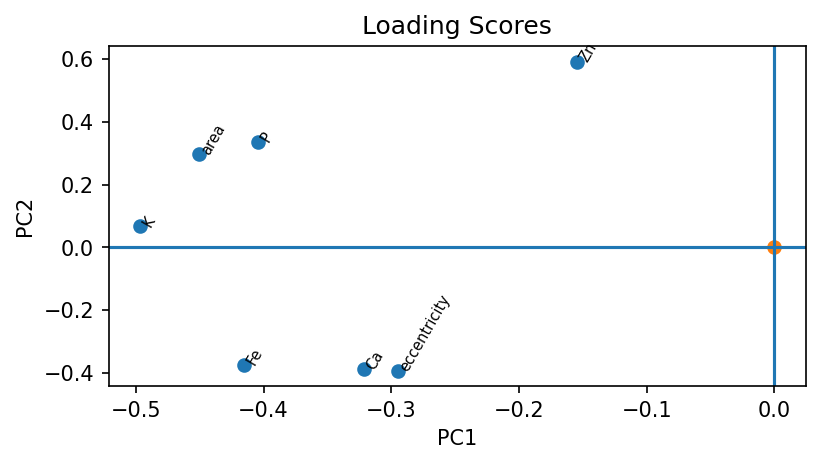

<Figure size 432x288 with 0 Axes>

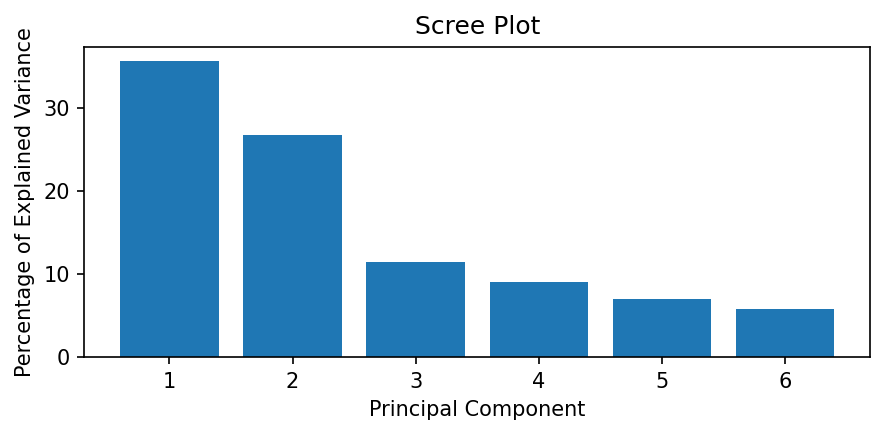

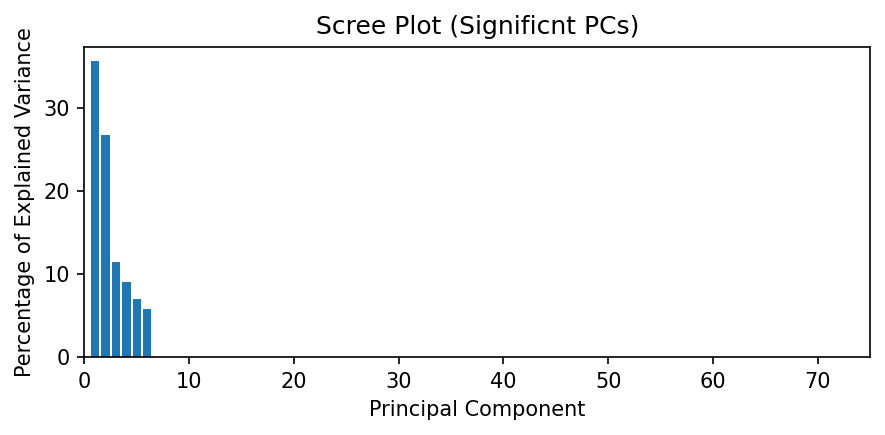

/tmp/ipykernel_24350/4082877442.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secondaryDf['PC1']=principalComponents[:,0]
/tmp/ipykernel_24350/4082877442.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secondaryDf['PC2']=principalComponents[:,1]


IndexError: index 2 is out of bounds for axis 1 with size 2

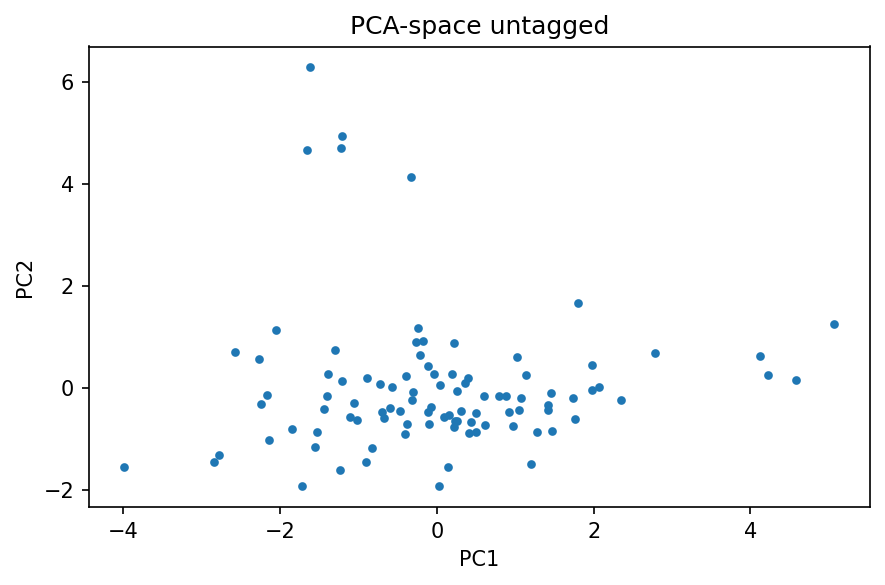

In [18]:
%matplotlib inline

# feature_names = ['area','eccentricity','equiv. dia.','major length','minor length','perimeter',
#         'K','P','Ca','Zn',
#          'Fe']

feature_names = ['area','eccentricity','K','P','Ca','Zn','Fe']


principalComponents, loading_scores = XRF_PCA(mod_X, feature_names, high_comp=6, n_components=2, 
                                              annot_txt_size=7, dpi =150, marker_size=3,save_plots=True)

#assign PC values to dataframe
secondaryDf['PC1']=principalComponents[:,0]
secondaryDf['PC2']=principalComponents[:,1]
secondaryDf['PC3']=principalComponents[:,2]



In [ ]:
# feature_list = ["area", "eccentricity","K","P"]
feature_list = ["area", "eccentricity", "K"]
# feature_list = ["K","P"]
# PC_names=["PC1", "PC2","PC3"]
PC_names=["PC1", "PC2"]

    
view_PC_feature_relation(secondaryDf,PC_names, feature_list, hue = 'scan_name',save_plots=True )

In [19]:
secondaryDf.head()

,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ca,...,avg_res,x_origin,y_origin,x_motor,y_motor,xrf_file,scan_name,original index,PC1,PC2
0,31,1.9375,0.883895,1.570637,2.291139,1.071534,5.035534,0.000042,0.000085,0.000074,...,0.253143,110.674377,-661.065186,175.174377,-654.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,0,-0.103280,-0.701801
1,24,1.5000,0.905991,1.381977,2.133281,0.903012,4.181981,0.000069,0.000055,0.000065,...,0.253143,110.674377,-661.065186,121.424377,-652.315186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,1,-0.108369,-0.472003
2,38,2.3750,0.937242,1.738949,2.952072,1.029325,6.096194,0.000054,0.000088,0.000078,...,0.253143,110.674377,-661.065186,178.674377,-648.065186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,2,-0.671520,-0.592457
3,34,2.1250,0.919664,1.644881,2.676460,1.051060,5.681981,0.000044,0.000089,0.000127,...,0.253143,110.674377,-661.065186,152.424377,-647.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,3,-0.412099,-0.897904
4,73,4.5625,0.981766,2.410219,5.681771,1.080060,11.303301,0.000055,0.000079,0.000064,...,0.253143,110.674377,-661.065186,135.424377,-645.315186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,4,-1.526107,-0.865514


In [20]:
# import plotly.express as px
fig = px.scatter_3d(secondaryDf, x='PC1', y='PC2', z='PC3', symbol='scan_name', size_max=5,
              color='eccentricity',size='area')

fig.update_traces(marker_size = 4)
fig.update_coloraxes(colorbar_orientation='h')
fig.update_layout(scene = dict(
                    xaxis_title='PC1',
                    yaxis_title='PC2',
                    zaxis_title='PC3'),
                    )
fig.show()
fig.write_image('../figures/PCA_eccentricity_3D.jpg')


ValueError: Value of 'z' is not the name of a column in 'data_frame'. Expected one of ['Pixel_count', 'area', 'eccentricity', 'equivalent_diameter', 'major_axis_length', 'minor_axis_length', 'perimeter', 'K', 'P', 'Ca', 'Zn', 'Fe', 'Cu', 'BFY', 'x_res', 'y_res', 'avg_res', 'x_origin', 'y_origin', 'x_motor', 'y_motor', 'xrf_file', 'scan_name', 'original index', 'PC1', 'PC2'] but received: PC3

# tag based off of experiments, so we can see the effect of sample prep.

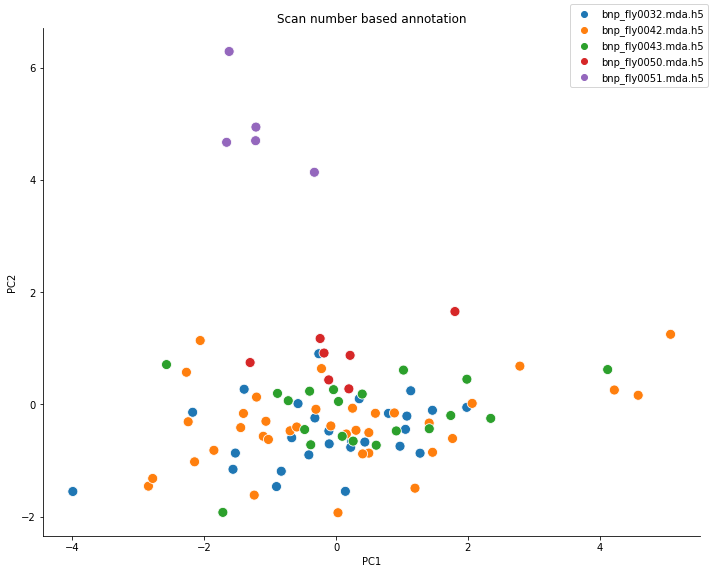

In [21]:
pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='scan_name', height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()
pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Scan number based annotation')
plt.tight_layout()

plt.savefig('../figures/pc_space_scan_tagged.jpg')

In [22]:
print(secondaryDf[['area','eccentricity', 'K','P','Ca','Zn','Fe']].to_latex(index=True))  

\begin{tabular}{lrrrrrrr}
\toprule
{} &    area &  eccentricity &         K &         P &        Ca &        Zn &        Fe \\
\midrule
0  &  1.9375 &      0.883895 &  0.000042 &  0.000085 &  0.000074 &  0.000071 &  0.000048 \\
1  &  1.5000 &      0.905991 &  0.000069 &  0.000055 &  0.000065 &  0.000051 &  0.000035 \\
2  &  2.3750 &      0.937242 &  0.000054 &  0.000088 &  0.000078 &  0.000055 &  0.000042 \\
3  &  2.1250 &      0.919664 &  0.000044 &  0.000089 &  0.000127 &  0.000077 &  0.000038 \\
4  &  4.5625 &      0.981766 &  0.000055 &  0.000079 &  0.000064 &  0.000049 &  0.000051 \\
5  &  1.9375 &      0.916829 &  0.000055 &  0.000073 &  0.000113 &  0.000045 &  0.000046 \\
6  &  3.5000 &      0.974489 &  0.000050 &  0.000099 &  0.000051 &  0.000058 &  0.000039 \\
7  &  1.3750 &      0.930661 &  0.000042 &  0.000062 &  0.000114 &  0.000069 &  0.000043 \\
8  &  4.9375 &      0.985921 &  0.000080 &  0.000094 &  0.000173 &  0.000061 &  0.000048 \\
9  &  0.9375 &      0.821501 &  0.00

/tmp/ipykernel_24350/2506169708.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(secondaryDf[['area','eccentricity', 'K','P','Ca','Zn','Fe']].to_latex(index=True))


# perform k-means

/tmp/ipykernel_24350/2630405428.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secondaryDf['Class'] = kmeans.labels_


inertia:  279.7386755136652


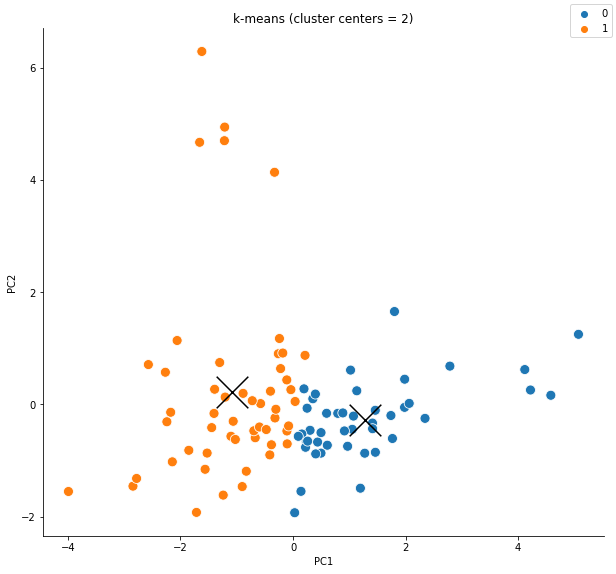

In [23]:


kmeans = KMeans(init="k-means++",n_clusters = 2, n_init=200, random_state = 42).fit(secondaryDf[['PC1','PC2']].to_numpy())
inertia=kmeans.inertia_
secondaryDf['Class'] = kmeans.labels_

print('inertia: ', inertia)
pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='Class', height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()
pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
pp.set(xlabel='PC1',
       ylabel='PC2',
       title='k-means (cluster centers = 2)')

plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], marker='x',s=1000, facecolors='black')
plt.tight_layout()
plt.savefig('../figures/pc_space_km_clustered.jpg')



# mark cluster boundaries

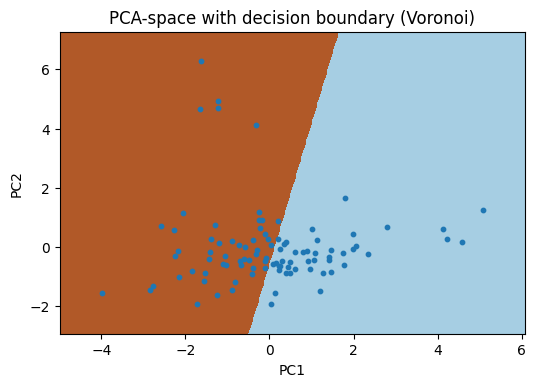

In [24]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = principalComponents[:, 0].min() - 1, principalComponents[:, 0].max() + 1
y_min, y_max = principalComponents[:, 1].min() - 1, principalComponents[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.figure(dpi=100)
plt.scatter(principalComponents[:,0],principalComponents[:,1], s=10)
plt.title('PCA-space with decision boundary (Voronoi)')
plt.xlabel('PC1')
plt.ylabel('PC2')



plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)


# use mean-shift

In [26]:
from sklearn.cluster import MeanShift, estimate_bandwidth


bandwidth = estimate_bandwidth(principalComponents, quantile=0.5)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(coarse_scans.X)
_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(ms.labels_)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 30


# apply scan based filter to annotate ideal cluster



Length true list:  84
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
dict_keys(['False', 'True'])


/tmp/ipykernel_24350/3348611444.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secondaryDf['text_labels'] = text_labels


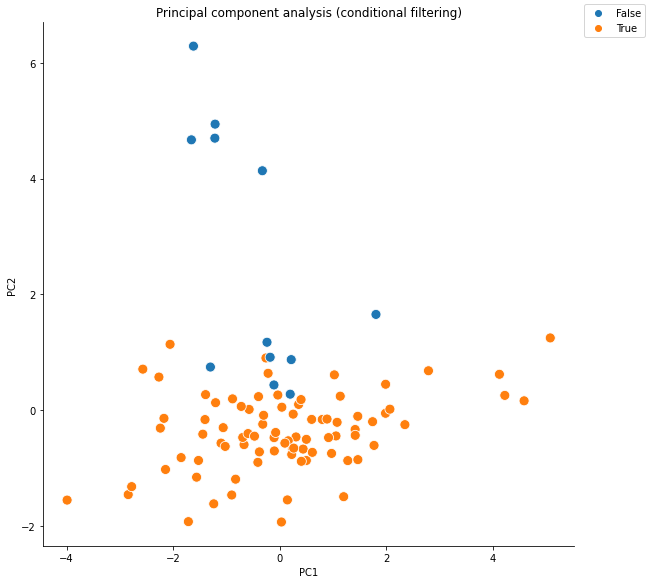

In [27]:
# condition check

labels = [0] * mod_X.shape[0]
text_labels=labels
True_list = secondaryDf.loc[
    (secondaryDf['scan_name']=='bnp_fly0032.mda.h5') | 
    (secondaryDf['scan_name']=='bnp_fly0042.mda.h5') | 
    (secondaryDf['scan_name']=='bnp_fly0043.mda.h5')  
   ].index.tolist()    
    
print('Length true list: ', len(True_list) )

for idx in True_list:
    labels[idx]=1 
print(labels)


y_dh=np.array(labels).astype(int)    #domain h labels
y=labels

RANGE=mod_X.shape[0]

for idx in range(RANGE):
    if text_labels[idx] ==0:
        text_labels[idx] = False
    if text_labels[idx] ==1:
        text_labels[idx] = True
        
secondaryDf['text_labels'] = text_labels

pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='text_labels',  height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()

pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
print(leg_labels)

pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis (conditional filtering)')



# count cells from each XRF

In [28]:
secondaryDf[secondaryDf['scan_name']=='bnp_fly0082.mda.h5'].count()

Pixel_count            0
area                   0
eccentricity           0
equivalent_diameter    0
major_axis_length      0
minor_axis_length      0
perimeter              0
K                      0
P                      0
Ca                     0
Zn                     0
Fe                     0
Cu                     0
BFY                    0
x_res                  0
y_res                  0
avg_res                0
x_origin               0
y_origin               0
x_motor                0
y_motor                0
xrf_file               0
scan_name              0
original index         0
PC1                    0
PC2                    0
Class                  0
text_labels            0
dtype: int64

# fuzzy k-means (currently works for 2 PCs)

In [29]:
df=secondaryDf

In [30]:
df

,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ca,...,y_origin,x_motor,y_motor,xrf_file,scan_name,original index,PC1,PC2,Class,text_labels
0,31,1.9375,0.883895,1.570637,2.291139,1.071534,5.035534,0.000042,0.000085,0.000074,...,-661.065186,175.174377,-654.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,0,-0.103280,-0.701801,1,True
1,24,1.5000,0.905991,1.381977,2.133281,0.903012,4.181981,0.000069,0.000055,0.000065,...,-661.065186,121.424377,-652.315186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,1,-0.108369,-0.472003,1,True
2,38,2.3750,0.937242,1.738949,2.952072,1.029325,6.096194,0.000054,0.000088,0.000078,...,-661.065186,178.674377,-648.065186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,2,-0.671520,-0.592457,1,True
3,34,2.1250,0.919664,1.644881,2.676460,1.051060,5.681981,0.000044,0.000089,0.000127,...,-661.065186,152.424377,-647.565186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,3,-0.412099,-0.897904,1,True
4,73,4.5625,0.981766,2.410219,5.681771,1.080060,11.303301,0.000055,0.000079,0.000064,...,-661.065186,135.424377,-645.315186,/data02/AZC/March_2022_XRF_Data/bnp_fly0032.md...,bnp_fly0032.mda.h5,4,-1.526107,-0.865514,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,74,4.6250,0.760358,2.426671,3.392264,2.203291,11.053301,0.000055,0.000127,0.000024,...,-91.956627,-4.888748,-76.206627,/data02/AZC/March_2022_XRF_Data/bnp_fly0051.md...,bnp_fly0051.mda.h5,140,-1.214503,4.939721,1,False
92,119,7.4375,0.833949,3.077291,4.255712,2.348479,10.949747,0.000040,0.000076,0.000016,...,-91.956627,-35.888748,-67.456627,/data02/AZC/March_2022_XRF_Data/bnp_fly0051.md...,bnp_fly0051.mda.h5,141,-0.328140,4.135178,1,False
93,133,8.3125,0.827593,3.253276,4.352950,2.443433,10.717514,0.000059,0.000120,0.000028,...,-91.956627,-51.138748,-60.706627,/data02/AZC/March_2022_XRF_Data/bnp_fly0051.md...,bnp_fly0051.mda.h5,142,-1.659067,4.668865,1,False
94,135,8.4375,0.502209,3.277645,3.553339,3.072737,10.571068,0.000066,0.000124,0.000027,...,-91.956627,-66.138748,-59.456627,/data02/AZC/March_2022_XRF_Data/bnp_fly0051.md...,bnp_fly0051.mda.h5,143,-1.620459,6.286509,1,False


In [31]:
#for 2 PCs
for i in range(3):
    df['p' + str(i)] = 0
    
# df[['p0', 'p1']] = soft_clustering_weights(X, kmeans.cluster_centers_)
df[['p0', 'p1']] = soft_clustering_weights(principalComponents, kmeans.cluster_centers_)
df['confidence'] = np.max(df[['p0', 'p1']].values, axis = 1)

/tmp/ipykernel_24350/994511390.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['p' + str(i)] = 0
/tmp/ipykernel_24350/994511390.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['p' + str(i)] = 0
/tmp/ipykernel_24350/994511390.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

In [32]:
df['confidence']

0     0.570318
1     0.651766
2     0.955859
3     0.782861
4     0.972142
        ...   
91    0.692185
92    0.657884
93    0.730073
94    0.658243
95    0.704539
Name: confidence, Length: 96, dtype: float64

In [33]:
np.unique(df['Class'].to_numpy())

array([0, 1], dtype=int32)

In [34]:
labels = [0] * mod_X.shape[0]
text_labels=labels
True_list = secondaryDf.loc[
    (secondaryDf['scan_name']=='bnp_fly0032.mda.h5') | 
    (secondaryDf['scan_name']=='bnp_fly0042.mda.h5') | 
    (secondaryDf['scan_name']=='bnp_fly0043.mda.h5')  
   ].index.tolist()       
    
print('Length true list: ', len(True_list) )

for idx in True_list:
    labels[idx]=1 
print(labels)
y_dh=np.array(labels).astype(int)

df['y']=y_dh
df['labels']=y_dh

Length true list:  84
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/tmp/ipykernel_24350/3048668556.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y']=y_dh
/tmp/ipykernel_24350/3048668556.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['labels']=y_dh


In [35]:
df['labels']

0     1
1     1
2     1
3     1
4     1
     ..
91    0
92    0
93    0
94    0
95    0
Name: labels, Length: 96, dtype: int64

In [36]:
# Make sure colours are the same for the actual class and the kmeans class in the plots.
# Count the most frequent species that appears in each class
df_color_converter = df.groupby('Class', as_index = False)['labels'].mean().round().astype(int)
color_converter_dict = {}
for ind in df_color_converter.index:
    color_converter_dict[ind] = df_color_converter.loc[ind, 'labels']
    
    

In [37]:
len(y_dh)

96

In [38]:
y_dh

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


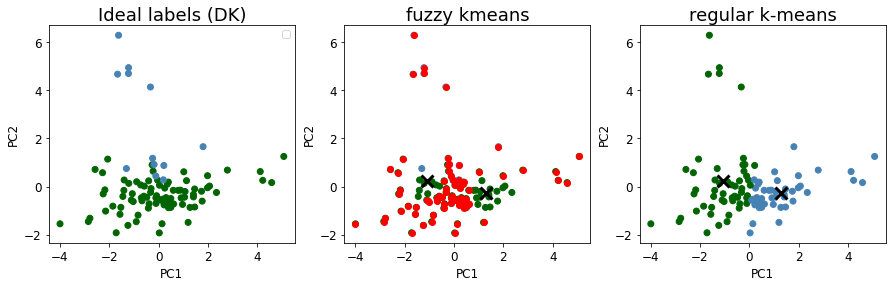

In [39]:
colors = [ 'steelblue', 'darkgreen']

fig, axs = plt.subplots(1, 3, figsize = (15,4))

ax = _format_soft_km_axes(axs[0])

ax.scatter(
    df[['PC1']].to_numpy(),
    df[['PC2']].to_numpy(),
    color = [colors[i] for i in y_dh]
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Ideal labels (DK)', pad = 5, fontsize = 18)
ax.legend()
plt.savefig('../figures/FCKM_ideal_labels.jpg')

# ax.set_ylim(-0.2, 2.7)
# ax.set_xlim(0.7, 7.3)

# ax.plot(
#     kmeans.cluster_centers_[:,-2],
#     kmeans.cluster_centers_[:,-1],
#     'xk',
#     markersize = 15,
#     markeredgewidth = 3
# )

ax = _format_soft_km_axes(axs[1])

confidence_threshold=0.99 #0.9 default

ax.scatter(
    df[['PC1']].to_numpy(),
    df[['PC2']].to_numpy(),
    color = [colors[i] for i in y_dh]
)

ax.scatter(
    df.loc[df['confidence'] < confidence_threshold, 'PC1'],
    df.loc[df['confidence'] < confidence_threshold, 'PC2'],
#     color = df.loc[df['confidence'] > confidence_threshold, 'Class'].apply(lambda x: colors[color_converter_dict[x]])
    color = ['red']
)

ax.plot(
    kmeans.cluster_centers_[:,-2],
    kmeans.cluster_centers_[:,-1],
    'xk',
    markersize = 12,
    markeredgewidth = 3
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('fuzzy kmeans', pad = 5, fontsize = 18)




ax = _format_soft_km_axes(axs[2])

ax.scatter(
    df[['PC1']].to_numpy(),
    df[['PC2']].to_numpy(),
    color = [colors[i] for i in kmeans.labels_]
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('regular k-means', pad = 5, fontsize = 18)


# ax.set_ylim(-0.2, 2.7)
# ax.set_xlim(0.7, 7.3)

ax.plot(
    kmeans.cluster_centers_[:,-2],
    kmeans.cluster_centers_[:,-1],
    'xk',
    markersize = 12,
    markeredgewidth = 3
)

plt.savefig('../figures/FCKM.jpg')


In [ ]:
#calculated clustering performance metrics

from sklearn import metrics

rand_index=metrics.rand_score(y_dh, kmeans.labels_)
print('unadjusted rand index [0,1]:',rand_index)
adj_rand_index=metrics.adjusted_rand_score(y_dh, kmeans.labels_)
print('adjusted rand index [-1,1]:',adj_rand_index)



In [ ]:
secondaryDf['x_res']

# apply a simple condition to filter the data

In [ ]:
# condition check

labels = [0] * mod_X.shape[0]

True_list = secondaryDf.loc[
    (secondaryDf['major_axis_length']>=1) & 
    (secondaryDf['major_axis_length']<= 3) &
    (secondaryDf['minor_axis_length']>=0.5) & 
    (secondaryDf['minor_axis_length']<= 1.5) &
    (secondaryDf['K']>=secondaryDf['K'].median()) &
    (secondaryDf['K']/secondaryDf['P']>=(secondaryDf['K']/secondaryDf['P']).median())
   ].index.tolist()    
    
print('Length true list: ', len(True_list) )

for idx in True_list:
    labels[idx]=1 

y_dh=labels    #domain h labels
y=labels
    
for idx in range(len(labels)):
    if labels[idx] ==0:
        labels[idx] = False
    if labels[idx] ==1:
        labels[idx] = True
        
secondaryDf['text_labels'] = labels

pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='text_labels',  height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()

pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
print(leg_labels)

pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis (conditional filtering)')



In [ ]:
# # look for outliers if exist
# secondaryDf[secondaryDf['PC2']>8]

In [ ]:
# # check if the filtering true false labels are correct

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     display(secondaryDf)

# secondaryDf['original index']

# view distribution of features for the two kmeans classes

In [ ]:
select_feature_channel = 'K'

secondaryDf[secondaryDf['Class']==0][select_feature_channel]
%matplotlib inline

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

sns.histplot(ax=ax[0],data=secondaryDf[secondaryDf['Class']==0], x=select_feature_channel, kde=True,color='blue')
ax[0].set_title('k-means (class = 0)')

sns.histplot(ax=ax[1],data=secondaryDf[secondaryDf['Class']==1], x=select_feature_channel, kde=True,color='orange')
ax[1].set_title('k-means (class = 1)')

# view the last xrf files extracted cells on the PC plot marked with orange

In [ ]:
# condition check

labels = [0] * mod_X.shape[0]

True_list = secondaryDf.loc[(secondaryDf['xrf_file']==current_xrf_filename)].index.tolist()    
    
print('Length true list: ', len(True_list) )

for idx in True_list:
    labels[idx]=1 
    
y=labels
    
for idx in range(len(labels)):
    if labels[idx] ==0:
        labels[idx] = 'previous XRF measurement'
    if labels[idx] ==1:
        labels[idx] = 'current measurement'
        
secondaryDf['text_labels'] = labels

pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='text_labels',  height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()

pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
print(leg_labels)

pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis  (current measurement))')



In [ ]:
%matplotlib notebook

subplot_kw = dict(autoscale_on=True)
fig, ax = plt.subplots(subplot_kw=subplot_kw)

# pts = ax.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], marker='x',s=1000,c=secondaryDf.Class, facecolors='black')
pts = ax.scatter(secondaryDf['PC1'].to_numpy(),secondaryDf['PC2'].to_numpy(), c=secondaryDf.Class,
                 cmap='winter')

# produce a legend with the unique colors from the scatter
legend = ax.legend(*pts.legend_elements(),
                    loc="upper left", title="Classes")
ax.add_artist(legend)

selector = SelectFromCollection(ax, pts)

fig.canvas.mpl_connect("key_press_event", accept)
ax.set_title("LIVE-DEAD Cell clusters\n Press enter to accept selected points. Select one point to view main XRF image")

plt.show()



In [ ]:
#shows selected indices in secondaryDf

print('number of selected cells:', len(selector.ind))

print('modified_indices:', selector.ind)

#conversions to original indices
target_scan_cell_indices = secondaryDf['original index'][selector.ind].to_numpy()
print('original indices:', target_scan_cell_indices)
print('K-means classes \n')
secondaryDf['Class'][selector.ind]

print('cell centers (pixel value in XRF image):' , X_centers[target_scan_cell_indices])
print('\n')
print('cell centers in x (pixel value in XRF image):' , X_centers[target_scan_cell_indices][0])
print('\n')
print('cell x_origins (motor coordinates):' , X_x_origin[target_scan_cell_indices])
print('\n')
print('cell y_origins (motor coordinates):' , X_y_origin[target_scan_cell_indices])

print('\n')
print('send to motor')
print('cell x_center (motor coordinates):' , X_x_motor[target_scan_cell_indices])
print('\n')
print('cell y_center (motor coordinates):' , X_y_motor[target_scan_cell_indices])
print('\n')

print('BBox motor width (x): ', BASE_PATCH_WIDTH*X_x_res[target_scan_cell_indices])
print('BBox motor width (y): ', BASE_PATCH_WIDTH*X_y_res[target_scan_cell_indices])


print('Main XRF image file (selected):' , X_xrf_track_files[target_scan_cell_indices])

motor_coordinates = np.vstack((X_x_motor[target_scan_cell_indices],X_y_motor[target_scan_cell_indices])).T
print(motor_coordinates)
